# Introduction

Online multiplayer games allow players to interact real-time over the internet, in virtual environments where they can play with or against each other. These games rely on servers to support large numbers of players simultaneously. Understanding the patterns of server demand is important, as it allows the research team to prevent server overload and provide a smooth gaming experience. Accurate demand forecasting ensures the number of licenses on hand is enough to accommodate all parallel players with high probability. The project will predict the time windows most likely to have a large number of simultaneous players using the sessions.csv dataset. This dataset is used as it provides us with the “start” and “end” time of a session. It also contains the date of a session, which helps us find out which time windows and which day of the week had the highest number of simultaneous players. Our project will answer the question: 

**What time windows are most likely to have large numbers of simultaneous players?**

# Loading the Data

We'll start by loading the data from the provided sessions.csv which can be found here: drive.google.com/file/d/14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB/

Note: file must be downloaded and placed in a data folder in the same directory as there is no way to import the data independently.

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
sessions <- "data/sessions.csv" |>
    read_csv()

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Then we can find the number of observations below

In [3]:
numrows <- sessions |>
    nrow()
sprintf("Number of Observations: %s", numrows)

[1] "Number of Observations: 1535"

# Summary of the Data

Hashed Email:

In [4]:
sessions |>
    select(hashedEmail) |>
    head(3)

hashedEmail
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc


Hashed email is an encrypted email identifying different players. The encryption allows the identity of the the players to stay anonymous while still allowing us to differentiate between different players while exploring the data. As our main goal is to find what time windows have the most online traffic, we are not really concerned with who is playing at what time so this column won't be as useful to us. 



Start/End Time:

In [5]:
sessions |>
    select(start_time, end_time) |>
    head(3)

start_time,end_time
<chr>,<chr>
30/06/2024 18:12,30/06/2024 18:24
17/06/2024 23:33,17/06/2024 23:46
25/07/2024 17:34,25/07/2024 17:57


Start time and end time columns contain the date in the dd/mm/yyyy format as well as the time using the 24 hour clock. The time data will be very useful in finding the busiest time slots during the day, however we'll need to tidy the data first since there are multiple pieces of data in each box. In addition to this, using this date format will be hard to inplement in R without modifications.

Original Start/End Time:

In [6]:
sessions |>
    select(original_start_time, original_end_time) |>
    head(3)

original_start_time,original_end_time
<dbl>,<dbl>
1.71977e+12,1.71977e+12
1.71867e+12,1.71867e+12
1.72193e+12,1.72193e+12


Original start and end time is the time in milliseconds Unix time. The Unix time, which is the time counted since January 1st 1970, is a common convention for keeping track of time in Computer Science due to the ease of using dbls instead of complex strings. For those reasons, this data will be very useful in our analysis.

# Wrangle and Cleaning the Data

Using the previously loaded in sessions file, the data will have to be tidied so that it can be used more effectively later.

To start, we'll rename the hashedEmail column to be consistent with the other columns and by separate starting and ending date and time into their own columns.

In [7]:
sessions_tidy <- sessions |>
    rename(hashed_email = hashedEmail, start_time1 = start_time, end_time1 = end_time) |> # temporary names added to start and end time to prevent errors in seperate
    separate(start_time1, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(end_time1, into = c('end_date', 'end_time'), sep = ' ')
head(sessions_tidy, 3)

hashed_email,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12


Great, next we'll have to convert start and end date and time to a useable form. We'll do that by creating a new column called weekdays and a column called month, made by converting our date to a Date type and then we'll convert our time to a numerical value. Finally, we'll create a length (in minutes) column by subtracting the start and end times.

In [8]:
sessions_wrangled <- sessions_tidy |>
# get weekdays
    mutate(weekday = as.factor(weekdays(strptime(start_date, "%d/%m/%Y")))) |>
# get months
    mutate(month = as.factor(months(strptime(start_date, "%d/%m/%Y")))) |>
# convert start_time
    separate(start_time, into = c('start_hour', 'start_minute'), sep = ':') |>
    mutate(start_time_dbl = as.numeric(start_hour) + (as.numeric(start_minute)/60))|>
# convert end_time
    separate(end_time, into = c('end_hour', 'end_minute'), sep = ':') |>
    mutate(end_time_dbl = as.numeric(end_hour) + (as.numeric(end_minute)/60))
# get the player count at given date and time for each observation by checking if date is the same and
# that the start time is inside the interval of (start time, end time) of any other observation
 sessions_count <- sessions_wrangled |>
    rowwise() |>
    mutate(player_count = sum(sessions_wrangled$start_date == start_date & 
      sessions_wrangled$start_time_dbl <= start_time_dbl & 
      sessions_wrangled$end_time_dbl >= start_time_dbl)) |>
# select only important columns
    select(player_count, weekday, month, start_time_dbl, start_hour)
head(sessions_count, 3)

player_count,weekday,month,start_time_dbl,start_hour
<int>,<fct>,<fct>,<dbl>,<chr>
3,Sunday,June,18.20000,18
1,Monday,June,23.55000,23
1,Thursday,July,17.56667,17


# Visualizations

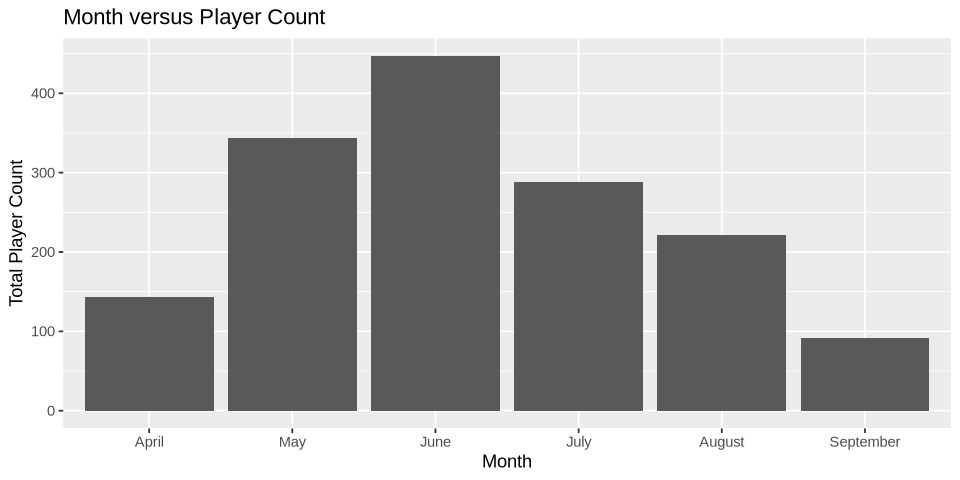

In [9]:
sessions_count$month <- factor(sessions_count$month, levels = c("April","May","June","July","August","September"))

options(repr.plot.height = 4, repr.plot.width = 8)
month_plot <- sessions_count |>
    ggplot(aes(x = month)) +
    geom_bar() +
    labs(x = "Month", y = "Total Player Count", title = "Month versus Player Count")
month_plot

The graph above illustrates the relationship between the total player count on the Minecraft server and the months the server has been active. Player activity appears to peak in June, reaching its highest count of over 400 players. Activity then gradually decreases in August, with the lowest participation observed in September, suggesting a potential seasonal trend in player engagement.

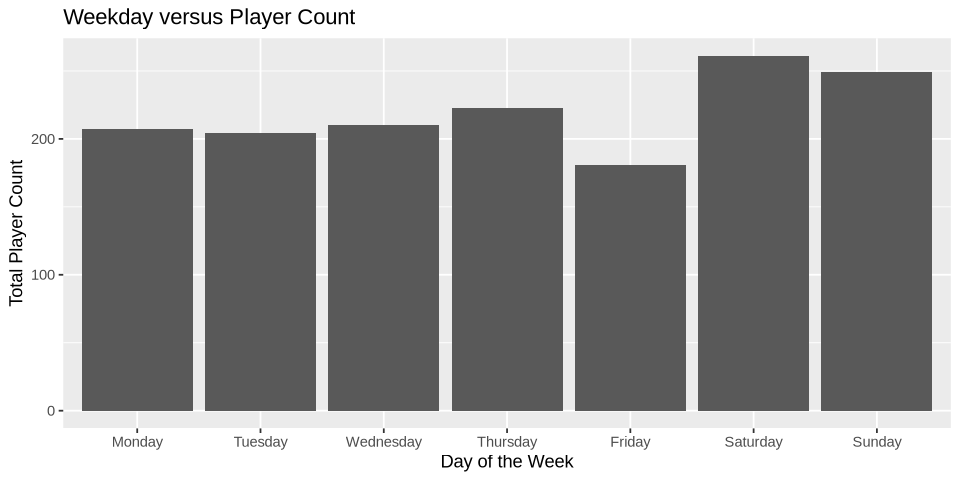

In [10]:
sessions_count$weekday <- factor(sessions_count$weekday, levels = c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))

options(repr.plot.height = 4, repr.plot.width = 8)
weekday_plot <- sessions_count |>
    ggplot(aes(x = weekday)) +
    geom_bar() +
    labs(x = "Day of the Week", y = "Total Player Count", title = "Weekday versus Player Count")
weekday_plot

The bar graph above shows the relationship between the total player count on the Minecraft server and the days of the week. Player activity is relatively consistent from Monday to Thursday, with an average count of just over 200 players. Activity dips slightly on Friday before significantly increasing on Saturday, which has the highest player count. Sunday also shows high engagement, slightly below Saturday. This suggests that player activity tends to rise during the weekend.

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_bar()`).”


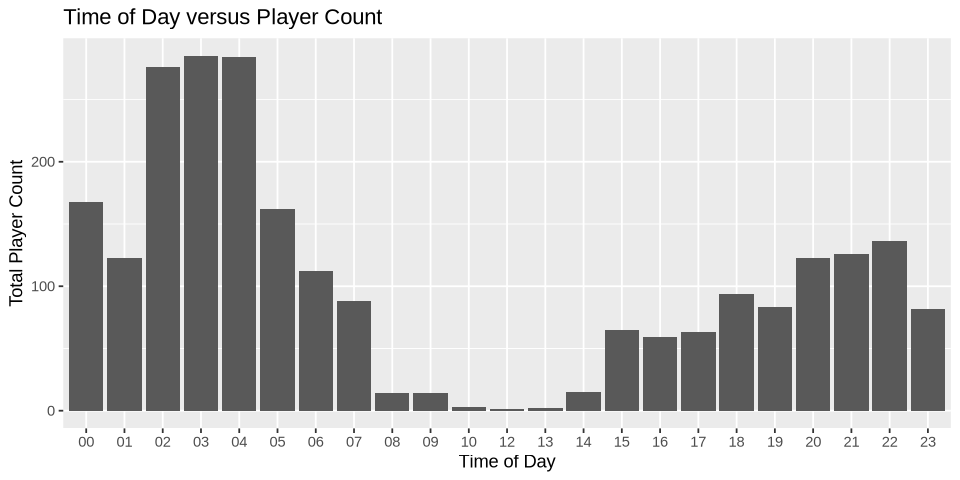

In [11]:
options(repr.plot.height = 4, repr.plot.width = 8)
weekday_plot <- sessions_count |>
    ggplot(aes(x = start_hour, y = player_count)) +
    geom_bar(stat = "identity") +
    labs(x = "Time of Day", y = "Total Player Count", title = "Time of Day versus Player Count")
weekday_plot

The bar graph above depicts the relationship between the total player count on a Minecraft server and the time of day. Player activity is highest during the late night and early morning hours, peaking around 2:00 AM to 4:00 AM. Activity steadily declines after 4:00 AM and is minimal between 8:00 AM and 2:00 PM, indicating low engagement during typical daytime hours. Player counts rise again during the evening, peaking between 8:00 PM and 11:00 PM. The spike of activity at such a peculiar time suggests that a large majority of the players in the server live in a different timezone.

# Data Analysis

To analyse the data, we'll try and create a knn regression model to predict the player count at a given time using the weekday, month and the time of day as predictors.

First we'll split the data into training and testing sets. A 60-40 split should be good for this model.

In [12]:
set.seed(1111) # DO NOT REMOVE
sessions_split <- sessions_count |>
    initial_split(prop = 0.6, strata = player_count)

sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

Next we'll find the best K value using cross validation.

In [13]:
set.seed(1111) # DO NOT REMOVE
sessions_recipe <- recipe(player_count ~ weekday + month + start_time_dbl, data = sessions_training) |>
    step_scale(start_time_dbl) |>
    step_center(start_time_dbl)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

sessions_workflow <- workflow() |>
    add_recipe(sessions_recipe) |>
    add_model(knn_spec)

sessions_vfold <- sessions_training |>
    vfold_cv(v = 5, strata = player_count)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_rmspe <- sessions_workflow |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean)
knn_rmspe


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,0.9109641,5,0.0341129,Preprocessor1_Model06


An rmse of 0.9109641 is not bad. We can examine the models performance on the testing set below.

In [14]:
set.seed(1111) # DO NOT REMOVE
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("regression")

sessions_fit <- workflow() |>
    add_recipe(sessions_recipe) |>
    add_model(knn_spec_2) |>
    fit(data = sessions_training)

sessions_prediction <- sessions_fit |>
    predict(sessions_testing) |>
    bind_cols(sessions_testing) 
tail(sessions_prediction, 5)

.pred,player_count,weekday,month,start_time_dbl,start_hour
<dbl>,<int>,<fct>,<fct>,<dbl>,<chr>
3.000000,2,Tuesday,July,3.733333,03
1.500000,1,Sunday,August,4.483333,04
1.333333,2,Sunday,May,15.083333,15
2.833333,2,Monday,July,4.133333,04
1.000000,1,Monday,May,2.433333,02


This shows that our model is pretty accurate at predicting the player count based on the day of the week, the month, and the time with an average error of ± ~1 player. This means that our model can reasonably predict the player count at any point in time given the predictor variables.

# Discussion

The analysis showed that the highest number of simultaneous players occurred in June and on Saturdays. Moreover, the highest simultaneous player count occurs at 3 am but 2 and 4 am also have relatively high player counts as well. This aligns with what we expected, as many students would be on summer break and are more likely to play during the weekends. Identifying the time windows with the largest number of simultaneous players will allow the game developers to make sure the server can handle a large capacity of players. Future questions could explore the impact that holidays have on player activity and how the peak time windows would differ in different regions.

# References

Ressources to help with dealing with the date format

https://www.geeksforgeeks.org/convert-date-to-day-of-week-in-r/

https://stackoverflow.com/questions/7439977/changing-date-format-in-r

Ressource to help with reordering bars on the barplot

https://stackoverflow.com/questions/3253641/order-discrete-x-scale-by-frequency-value